In [1]:
import sklearn as skl
import pickle as pkl
import pandas as pd
import numpy as np

import sklearn.model_selection
import sklearn.svm
import sklearn.metrics

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import seaborn as sns

from itertools import chain

In [2]:
import scipy as sp

In [3]:
import math
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data

In [4]:
import sys
sys.path.append("..") # or wherever the package is
import kuanglu

In [5]:
import scanpy as sc

In [6]:
import pickle as pkl

In [7]:
import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "4"

## Create dataloaders

Note: samples must have the same number of genes (and of course in the same order). They can, however, have different number of cells, but you'll only be able to use `batch_size = 1`, because we matrices with different sizes cannot form a tensor.

It is possible in the future, by flanking them with zeros and carefully masking them out in several steps.

In [9]:
adatas = []

ids = ["H18.06.006.MTG.4000.expand.rep1",
       "H18.06.006.MTG.4000.expand.rep2",
       "H18.06.006.MTG.4000.expand.rep3",
       "H22.26.401.MTG.4000.expand.rep1",
       "H22.26.401.MTG.4000.expand.rep2",
       "H19.30.001.STG.4000.expand.rep1",
       "H19.30.001.STG.4000.expand.rep2",
       "H20.30.001.STG.4000.expand.rep1",
       "H20.30.001.STG.4000.expand.rep2",
       "H20.30.001.STG.4000.expand.rep3"]

for id in ids:
    data_dir = '../../data/human-brain/'
    obs = pd.read_csv(os.path.join(data_dir, f"{id}.features.csv"), index_col=0)
    var = pd.read_csv(os.path.join(data_dir, f"{id}.genes.csv"), index_col=0)
    data = pd.read_csv(os.path.join(data_dir, f"{id}.matrix.csv"))

    temp_adata = sc.AnnData(X=sp.sparse.csr_matrix((data['val'], (data['col'] - 1, data['row'] - 1)), 
                                               shape=(len(obs), len(var))),
                       obs=obs,
                       var=var)
    temp_adata.obs['sample'] = id
    sc.pp.normalize_total(temp_adata)
    sc.pp.log1p(temp_adata)

    temp_adata.raw = temp_adata.copy()
    sc.pp.scale(temp_adata)
    adatas.append(temp_adata)
    
adata = sc.concat(adatas)

C:\Users\lshh\miniconda3\envs\torch_2.0.1\lib\site-packages\anndata\_core\merge.py:217: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(dtype):
C:\Users\lshh\miniconda3\envs\torch_2.0.1\lib\site-packages\anndata\_core\anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
C:\Users\lshh\miniconda3\envs\torch_2.0.1\lib\site-packages\anndata\_core\anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [11]:
train_Xs = []
for i in ids:
    train_Xs.append(np.array(adata.X[adata.obs['sample'] == i, :]))
    
validate_Xs = []
chosen_donors = ids[0:1]
for i in chosen_donors:
    validate_Xs.append(np.array(adata.X[adata.obs['sample'] == i, :]))
    
_, p = train_Xs[0].shape

class MyDataSet(Data.Dataset):
    def __init__(self, Xs):
        super(MyDataSet, self).__init__()
        self.Xs = [torch.Tensor(X) for X in Xs]
        
    def __len__(self):
        return len(self.Xs)

    def __getitem__(self, idx):
        return self.Xs[idx]

train_data = MyDataSet(train_Xs)
train_loader = Data.DataLoader(train_data, batch_size=1, shuffle=True) 

print("Training data dimensions:")
for i in train_Xs:
    print(i.shape)

validate_data = MyDataSet(validate_Xs)
validate_loader = Data.DataLoader(validate_data, batch_size=1, shuffle=True)

print("Validation data dimensions:")
for i in validate_Xs:
    print(i.shape)

Training data dimensions:
(3044, 3999)
(4045, 3999)
(3970, 3999)
(4321, 3999)
(3512, 3999)
(4835, 3999)
(5610, 3999)
(6135, 3999)
(4871, 3999)
(3918, 3999)
Validation data dimensions:
(3044, 3999)


In [15]:
embed_config = {
    'embedType': 'ff',
    'ldim': [3999, 512, 256, 128],
}

model = kuanglu.Model(d_gene=p, 
                      d_denoise = [p], 
                      d_quality=[512, 256, 1], 
                      lbd=1.,
                      embed_config=embed_config,
                      ).to('cuda')

In [16]:
rec = model.fit('denoised', train_loader, validate_loader, [0, 500],
                fix=['embed', 'qualify', 'smooth', 'interact'], lr=1e-4)

G:\kuanglu\examples\..\kuanglu\model.py:312: UserWarning: Parameter containing:
tensor(100., device='cuda:0') is already fixed. They will be unfixed when exiting this function.
  warnings.warn(f"{param} is already fixed. They will be unfixed when exiting this function.")


Epoch 0001 Train MSE 0.942 Validate MSE 1.009 Raw MSE 1.004
Epoch 0002 Train MSE 0.933 Validate MSE 0.969 Raw MSE 0.984
Epoch 0003 Train MSE 0.920 Validate MSE 0.962 Raw MSE 0.997
Epoch 0004 Train MSE 0.915 Validate MSE 0.943 Raw MSE 0.991
Epoch 0005 Train MSE 0.907 Validate MSE 0.961 Raw MSE 1.019
Epoch 0006 Train MSE 0.894 Validate MSE 0.942 Raw MSE 1.009
Epoch 0007 Train MSE 0.891 Validate MSE 0.926 Raw MSE 1.001
Epoch 0008 Train MSE 0.893 Validate MSE 0.926 Raw MSE 1.007
Epoch 0009 Train MSE 0.886 Validate MSE 0.912 Raw MSE 0.997
Epoch 0010 Train MSE 0.883 Validate MSE 0.897 Raw MSE 0.991
Epoch 0011 Train MSE 0.883 Validate MSE 0.920 Raw MSE 1.015
Epoch 0012 Train MSE 0.882 Validate MSE 0.897 Raw MSE 0.993
Epoch 0013 Train MSE 0.877 Validate MSE 0.889 Raw MSE 0.987
Epoch 0014 Train MSE 0.875 Validate MSE 0.900 Raw MSE 1.003
Epoch 0015 Train MSE 0.880 Validate MSE 0.905 Raw MSE 1.009
Epoch 0016 Train MSE 0.876 Validate MSE 0.896 Raw MSE 1.002
Epoch 0017 Train MSE 0.876 Validate MSE 

Epoch 0138 Train MSE 0.869 Validate MSE 0.881 Raw MSE 1.007
Epoch 0139 Train MSE 0.864 Validate MSE 0.880 Raw MSE 1.002
Epoch 0140 Train MSE 0.866 Validate MSE 0.885 Raw MSE 1.009
Epoch 0141 Train MSE 0.863 Validate MSE 0.886 Raw MSE 1.008
Epoch 0142 Train MSE 0.865 Validate MSE 0.863 Raw MSE 0.988
Epoch 0143 Train MSE 0.867 Validate MSE 0.876 Raw MSE 1.001
Epoch 0144 Train MSE 0.866 Validate MSE 0.876 Raw MSE 1.000
Epoch 0145 Train MSE 0.861 Validate MSE 0.868 Raw MSE 0.993
Epoch 0146 Train MSE 0.863 Validate MSE 0.884 Raw MSE 1.009
Epoch 0147 Train MSE 0.864 Validate MSE 0.884 Raw MSE 1.011
Epoch 0148 Train MSE 0.860 Validate MSE 0.850 Raw MSE 0.980
Epoch 0149 Train MSE 0.867 Validate MSE 0.875 Raw MSE 1.001
Epoch 0150 Train MSE 0.862 Validate MSE 0.867 Raw MSE 0.990
Epoch 0151 Train MSE 0.861 Validate MSE 0.869 Raw MSE 0.998
Epoch 0152 Train MSE 0.865 Validate MSE 0.876 Raw MSE 1.003
Epoch 0153 Train MSE 0.865 Validate MSE 0.871 Raw MSE 0.999
Epoch 0154 Train MSE 0.869 Validate MSE 

Epoch 0275 Train MSE 0.861 Validate MSE 0.861 Raw MSE 0.988
Epoch 0276 Train MSE 0.867 Validate MSE 0.864 Raw MSE 0.989
Epoch 0277 Train MSE 0.862 Validate MSE 0.858 Raw MSE 0.985
Epoch 0278 Train MSE 0.866 Validate MSE 0.884 Raw MSE 1.011
Epoch 0279 Train MSE 0.870 Validate MSE 0.864 Raw MSE 0.988
Epoch 0280 Train MSE 0.865 Validate MSE 0.875 Raw MSE 1.001
Epoch 0281 Train MSE 0.860 Validate MSE 0.877 Raw MSE 1.006
Epoch 0282 Train MSE 0.865 Validate MSE 0.869 Raw MSE 0.993
Epoch 0283 Train MSE 0.862 Validate MSE 0.862 Raw MSE 0.988
Epoch 0284 Train MSE 0.860 Validate MSE 0.876 Raw MSE 1.001
Epoch 0285 Train MSE 0.869 Validate MSE 0.865 Raw MSE 0.993
Epoch 0286 Train MSE 0.858 Validate MSE 0.869 Raw MSE 0.998
Epoch 0287 Train MSE 0.862 Validate MSE 0.879 Raw MSE 1.004
Epoch 0288 Train MSE 0.868 Validate MSE 0.861 Raw MSE 0.990
Epoch 0289 Train MSE 0.860 Validate MSE 0.870 Raw MSE 0.995
Epoch 0290 Train MSE 0.868 Validate MSE 0.871 Raw MSE 0.992
Epoch 0291 Train MSE 0.859 Validate MSE 

Epoch 0412 Train MSE 0.858 Validate MSE 0.871 Raw MSE 0.998
Epoch 0413 Train MSE 0.866 Validate MSE 0.875 Raw MSE 1.003
Epoch 0414 Train MSE 0.871 Validate MSE 0.894 Raw MSE 1.017
Epoch 0415 Train MSE 0.860 Validate MSE 0.877 Raw MSE 1.004
Epoch 0416 Train MSE 0.858 Validate MSE 0.875 Raw MSE 1.003
Epoch 0417 Train MSE 0.861 Validate MSE 0.870 Raw MSE 0.996
Epoch 0418 Train MSE 0.862 Validate MSE 0.861 Raw MSE 0.987
Epoch 0419 Train MSE 0.860 Validate MSE 0.880 Raw MSE 1.007
Epoch 0420 Train MSE 0.860 Validate MSE 0.881 Raw MSE 1.008
Epoch 0421 Train MSE 0.858 Validate MSE 0.877 Raw MSE 1.004
Epoch 0422 Train MSE 0.866 Validate MSE 0.874 Raw MSE 0.999
Epoch 0423 Train MSE 0.853 Validate MSE 0.886 Raw MSE 1.017
Epoch 0424 Train MSE 0.865 Validate MSE 0.886 Raw MSE 1.013
Epoch 0425 Train MSE 0.862 Validate MSE 0.885 Raw MSE 1.011
Epoch 0426 Train MSE 0.863 Validate MSE 0.880 Raw MSE 1.007
Epoch 0427 Train MSE 0.866 Validate MSE 0.865 Raw MSE 0.992
Epoch 0428 Train MSE 0.869 Validate MSE 

In [17]:
rec = kuanglu.record_concat(rec, model.fit('smoothed', train_loader, validate_loader, [500, 750],
                                           fix=['denoise', 'interact'], lr=1e-4))
rec = kuanglu.record_concat(rec, model.fit('smoothed', train_loader, validate_loader, [750, 1000],
                                           fix=['interact'], lr=1e-4))

Epoch 0501 Train MSE 0.915 Validate MSE 0.969 Raw MSE 1.006
Epoch 0502 Train MSE 0.903 Validate MSE 0.949 Raw MSE 1.001
Epoch 0503 Train MSE 0.899 Validate MSE 0.913 Raw MSE 0.989
Epoch 0504 Train MSE 0.896 Validate MSE 0.932 Raw MSE 1.019
Epoch 0505 Train MSE 0.889 Validate MSE 0.900 Raw MSE 0.988
Epoch 0506 Train MSE 0.885 Validate MSE 0.898 Raw MSE 0.984
Epoch 0507 Train MSE 0.880 Validate MSE 0.916 Raw MSE 1.004
Epoch 0508 Train MSE 0.880 Validate MSE 0.908 Raw MSE 0.997
Epoch 0509 Train MSE 0.879 Validate MSE 0.915 Raw MSE 1.011
Epoch 0510 Train MSE 0.868 Validate MSE 0.896 Raw MSE 0.997
Epoch 0511 Train MSE 0.877 Validate MSE 0.896 Raw MSE 0.990
Epoch 0512 Train MSE 0.876 Validate MSE 0.914 Raw MSE 1.006
Epoch 0513 Train MSE 0.881 Validate MSE 0.895 Raw MSE 0.997
Epoch 0514 Train MSE 0.879 Validate MSE 0.891 Raw MSE 0.991
Epoch 0515 Train MSE 0.875 Validate MSE 0.888 Raw MSE 0.983
Epoch 0516 Train MSE 0.878 Validate MSE 0.897 Raw MSE 1.000
Epoch 0517 Train MSE 0.875 Validate MSE 

Epoch 0638 Train MSE 0.863 Validate MSE 0.859 Raw MSE 0.985
Epoch 0639 Train MSE 0.863 Validate MSE 0.868 Raw MSE 0.998
Epoch 0640 Train MSE 0.866 Validate MSE 0.871 Raw MSE 0.998
Epoch 0641 Train MSE 0.860 Validate MSE 0.863 Raw MSE 0.993
Epoch 0642 Train MSE 0.862 Validate MSE 0.869 Raw MSE 0.994
Epoch 0643 Train MSE 0.856 Validate MSE 0.861 Raw MSE 0.990
Epoch 0644 Train MSE 0.864 Validate MSE 0.862 Raw MSE 0.993
Epoch 0645 Train MSE 0.864 Validate MSE 0.880 Raw MSE 1.005
Epoch 0646 Train MSE 0.862 Validate MSE 0.852 Raw MSE 0.985
Epoch 0647 Train MSE 0.863 Validate MSE 0.870 Raw MSE 1.001
Epoch 0648 Train MSE 0.863 Validate MSE 0.872 Raw MSE 0.997
Epoch 0649 Train MSE 0.863 Validate MSE 0.873 Raw MSE 1.002
Epoch 0650 Train MSE 0.861 Validate MSE 0.863 Raw MSE 0.990
Epoch 0651 Train MSE 0.858 Validate MSE 0.878 Raw MSE 1.006
Epoch 0652 Train MSE 0.862 Validate MSE 0.877 Raw MSE 1.006
Epoch 0653 Train MSE 0.861 Validate MSE 0.861 Raw MSE 0.991
Epoch 0654 Train MSE 0.866 Validate MSE 

Epoch 0775 Train MSE 0.863 Validate MSE 0.875 Raw MSE 1.002
Epoch 0776 Train MSE 0.863 Validate MSE 0.882 Raw MSE 1.007
Epoch 0777 Train MSE 0.862 Validate MSE 0.868 Raw MSE 0.992
Epoch 0778 Train MSE 0.860 Validate MSE 0.869 Raw MSE 0.996
Epoch 0779 Train MSE 0.857 Validate MSE 0.876 Raw MSE 1.003
Epoch 0780 Train MSE 0.860 Validate MSE 0.862 Raw MSE 0.989
Epoch 0781 Train MSE 0.863 Validate MSE 0.869 Raw MSE 0.998
Epoch 0782 Train MSE 0.860 Validate MSE 0.880 Raw MSE 1.003
Epoch 0783 Train MSE 0.861 Validate MSE 0.888 Raw MSE 1.011
Epoch 0784 Train MSE 0.862 Validate MSE 0.862 Raw MSE 0.988
Epoch 0785 Train MSE 0.861 Validate MSE 0.887 Raw MSE 1.015
Epoch 0786 Train MSE 0.866 Validate MSE 0.873 Raw MSE 1.000
Epoch 0787 Train MSE 0.861 Validate MSE 0.875 Raw MSE 1.002
Epoch 0788 Train MSE 0.861 Validate MSE 0.876 Raw MSE 1.003
Epoch 0789 Train MSE 0.860 Validate MSE 0.867 Raw MSE 0.992
Epoch 0790 Train MSE 0.861 Validate MSE 0.870 Raw MSE 0.999
Epoch 0791 Train MSE 0.861 Validate MSE 

Epoch 0912 Train MSE 0.862 Validate MSE 0.876 Raw MSE 1.001
Epoch 0913 Train MSE 0.863 Validate MSE 0.881 Raw MSE 1.002
Epoch 0914 Train MSE 0.868 Validate MSE 0.870 Raw MSE 0.995
Epoch 0915 Train MSE 0.861 Validate MSE 0.871 Raw MSE 0.998
Epoch 0916 Train MSE 0.865 Validate MSE 0.890 Raw MSE 1.013
Epoch 0917 Train MSE 0.859 Validate MSE 0.868 Raw MSE 0.992
Epoch 0918 Train MSE 0.864 Validate MSE 0.872 Raw MSE 0.994
Epoch 0919 Train MSE 0.856 Validate MSE 0.881 Raw MSE 1.002
Epoch 0920 Train MSE 0.864 Validate MSE 0.880 Raw MSE 0.997
Epoch 0921 Train MSE 0.865 Validate MSE 0.871 Raw MSE 0.993
Epoch 0922 Train MSE 0.867 Validate MSE 0.864 Raw MSE 0.985
Epoch 0923 Train MSE 0.863 Validate MSE 0.889 Raw MSE 1.010
Epoch 0924 Train MSE 0.863 Validate MSE 0.873 Raw MSE 0.996
Epoch 0925 Train MSE 0.863 Validate MSE 0.868 Raw MSE 0.993
Epoch 0926 Train MSE 0.858 Validate MSE 0.874 Raw MSE 0.994
Epoch 0927 Train MSE 0.864 Validate MSE 0.875 Raw MSE 0.998
Epoch 0928 Train MSE 0.863 Validate MSE 

In [18]:
rec = kuanglu.record_concat(rec, model.fit('final', train_loader, validate_loader, [1000, 1250],
                                           fix=['denoise', 'embed', 'qualify', 'smooth'], lr=1e-4))
rec = kuanglu.record_concat(rec, model.fit('final', train_loader, validate_loader, [1250, 1500], lr=1e-4))

Epoch 1001 Train MSE 0.866 Validate MSE 0.864 Raw MSE 0.985
Epoch 1002 Train MSE 0.865 Validate MSE 0.879 Raw MSE 0.998
Epoch 1003 Train MSE 0.870 Validate MSE 0.873 Raw MSE 0.991
Epoch 1004 Train MSE 0.866 Validate MSE 0.876 Raw MSE 0.995
Epoch 1005 Train MSE 0.866 Validate MSE 0.882 Raw MSE 1.002
Epoch 1006 Train MSE 0.862 Validate MSE 0.872 Raw MSE 0.992
Epoch 1007 Train MSE 0.867 Validate MSE 0.873 Raw MSE 0.988
Epoch 1008 Train MSE 0.856 Validate MSE 0.869 Raw MSE 0.991
Epoch 1009 Train MSE 0.866 Validate MSE 0.877 Raw MSE 1.000
Epoch 1010 Train MSE 0.859 Validate MSE 0.875 Raw MSE 0.994
Epoch 1011 Train MSE 0.866 Validate MSE 0.863 Raw MSE 0.986
Epoch 1012 Train MSE 0.860 Validate MSE 0.879 Raw MSE 0.999
Epoch 1013 Train MSE 0.867 Validate MSE 0.879 Raw MSE 0.999
Epoch 1014 Train MSE 0.862 Validate MSE 0.861 Raw MSE 0.982
Epoch 1015 Train MSE 0.867 Validate MSE 0.879 Raw MSE 1.000
Epoch 1016 Train MSE 0.866 Validate MSE 0.876 Raw MSE 0.999
Epoch 1017 Train MSE 0.866 Validate MSE 

Epoch 1138 Train MSE 0.860 Validate MSE 0.873 Raw MSE 0.995
Epoch 1139 Train MSE 0.864 Validate MSE 0.893 Raw MSE 1.014
Epoch 1140 Train MSE 0.858 Validate MSE 0.873 Raw MSE 0.994
Epoch 1141 Train MSE 0.859 Validate MSE 0.882 Raw MSE 1.002
Epoch 1142 Train MSE 0.860 Validate MSE 0.866 Raw MSE 0.991
Epoch 1143 Train MSE 0.862 Validate MSE 0.857 Raw MSE 0.981
Epoch 1144 Train MSE 0.864 Validate MSE 0.875 Raw MSE 0.998
Epoch 1145 Train MSE 0.865 Validate MSE 0.876 Raw MSE 0.999
Epoch 1146 Train MSE 0.859 Validate MSE 0.874 Raw MSE 0.994
Epoch 1147 Train MSE 0.861 Validate MSE 0.881 Raw MSE 1.004
Epoch 1148 Train MSE 0.865 Validate MSE 0.878 Raw MSE 1.000
Epoch 1149 Train MSE 0.861 Validate MSE 0.869 Raw MSE 0.992
Epoch 1150 Train MSE 0.861 Validate MSE 0.876 Raw MSE 0.998
Epoch 1151 Train MSE 0.866 Validate MSE 0.873 Raw MSE 0.994
Epoch 1152 Train MSE 0.865 Validate MSE 0.883 Raw MSE 1.005
Epoch 1153 Train MSE 0.856 Validate MSE 0.891 Raw MSE 1.015
Epoch 1154 Train MSE 0.859 Validate MSE 

Epoch 1275 Train MSE 0.860 Validate MSE 0.873 Raw MSE 0.995
Epoch 1276 Train MSE 0.867 Validate MSE 0.872 Raw MSE 0.994
Epoch 1277 Train MSE 0.866 Validate MSE 0.858 Raw MSE 0.981
Epoch 1278 Train MSE 0.863 Validate MSE 0.899 Raw MSE 1.019
Epoch 1279 Train MSE 0.856 Validate MSE 0.860 Raw MSE 0.985
Epoch 1280 Train MSE 0.865 Validate MSE 0.863 Raw MSE 0.986
Epoch 1281 Train MSE 0.865 Validate MSE 0.879 Raw MSE 0.999
Epoch 1282 Train MSE 0.866 Validate MSE 0.879 Raw MSE 0.999
Epoch 1283 Train MSE 0.859 Validate MSE 0.870 Raw MSE 0.990
Epoch 1284 Train MSE 0.859 Validate MSE 0.876 Raw MSE 0.998
Epoch 1285 Train MSE 0.867 Validate MSE 0.883 Raw MSE 1.007
Epoch 1286 Train MSE 0.858 Validate MSE 0.892 Raw MSE 1.018
Epoch 1287 Train MSE 0.861 Validate MSE 0.880 Raw MSE 1.006
Epoch 1288 Train MSE 0.859 Validate MSE 0.872 Raw MSE 0.998
Epoch 1289 Train MSE 0.861 Validate MSE 0.875 Raw MSE 0.999
Epoch 1290 Train MSE 0.865 Validate MSE 0.877 Raw MSE 1.001
Epoch 1291 Train MSE 0.865 Validate MSE 

Epoch 1412 Train MSE 0.859 Validate MSE 0.870 Raw MSE 0.991
Epoch 1413 Train MSE 0.861 Validate MSE 0.865 Raw MSE 0.988
Epoch 1414 Train MSE 0.861 Validate MSE 0.881 Raw MSE 1.001
Epoch 1415 Train MSE 0.857 Validate MSE 0.871 Raw MSE 0.990
Epoch 1416 Train MSE 0.862 Validate MSE 0.879 Raw MSE 1.000
Epoch 1417 Train MSE 0.858 Validate MSE 0.867 Raw MSE 0.992
Epoch 1418 Train MSE 0.859 Validate MSE 0.870 Raw MSE 0.993
Epoch 1419 Train MSE 0.866 Validate MSE 0.885 Raw MSE 1.008
Epoch 1420 Train MSE 0.863 Validate MSE 0.873 Raw MSE 0.994
Epoch 1421 Train MSE 0.859 Validate MSE 0.884 Raw MSE 1.006
Epoch 1422 Train MSE 0.861 Validate MSE 0.868 Raw MSE 0.990
Epoch 1423 Train MSE 0.862 Validate MSE 0.897 Raw MSE 1.017
Epoch 1424 Train MSE 0.857 Validate MSE 0.858 Raw MSE 0.985
Epoch 1425 Train MSE 0.860 Validate MSE 0.879 Raw MSE 0.999
Epoch 1426 Train MSE 0.853 Validate MSE 0.885 Raw MSE 1.007
Epoch 1427 Train MSE 0.862 Validate MSE 0.861 Raw MSE 0.985
Epoch 1428 Train MSE 0.862 Validate MSE 

Text(0, 0.5, 'MSE')

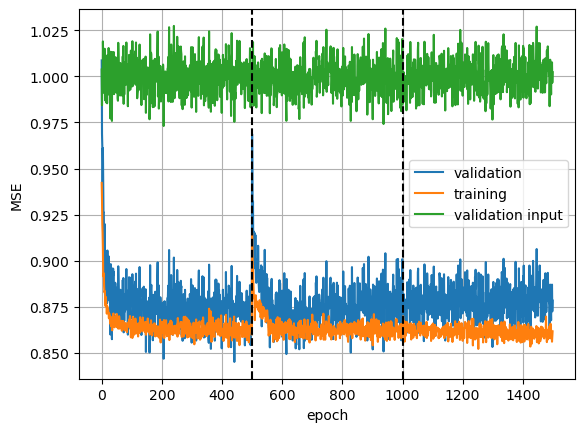

In [19]:
plt.plot(rec['validate_epoch'], rec['validate_mse'], label='validation')
plt.plot(rec['train_epoch'], rec['train_mse'], label='training')
plt.plot(rec['validate_epoch'], rec['raw_mse'], label='validation input')
plt.legend()
plt.grid()
plt.axvline(500, ls='--', c='k')
plt.axvline(1000, ls='--', c='k')
plt.xlabel('epoch')
plt.ylabel('MSE')

In [20]:
mse_df = pd.DataFrame({'epoch': rec['validate_epoch'], 'mse': rec['validate_mse']})

def epoch2stage(x):
    if x < 250: return 'pre-denoise'
    elif x < 500: return 'denoise'
    elif x < 750: return 'pre-denoise-smooth'
    elif x < 1000: return 'denoise-smooth'
    elif x < 1250: return 'pre-denoise-smooth-enhance'
    elif x < 1500: return 'denoise-smooth-enhance'
    else: raise NotImplementedError('x >= 400 not allowed')

mse_df['stage'] = mse_df['epoch'].apply(epoch2stage)
mse_df

,epoch,mse,stage
0,0,1.008659,pre-denoise
1,1,0.968869,pre-denoise
2,2,0.962028,pre-denoise
3,3,0.942603,pre-denoise
4,4,0.961092,pre-denoise
...,...,...,...
1495,1495,0.878746,denoise-smooth-enhance
1496,1496,0.881420,denoise-smooth-enhance
1497,1497,0.886999,denoise-smooth-enhance
1498,1498,0.872481,denoise-smooth-enhance


C:\Users\lshh\miniconda3\envs\torch_2.0.1\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\lshh\miniconda3\envs\torch_2.0.1\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\lshh\miniconda3\envs\torch_2.0.1\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


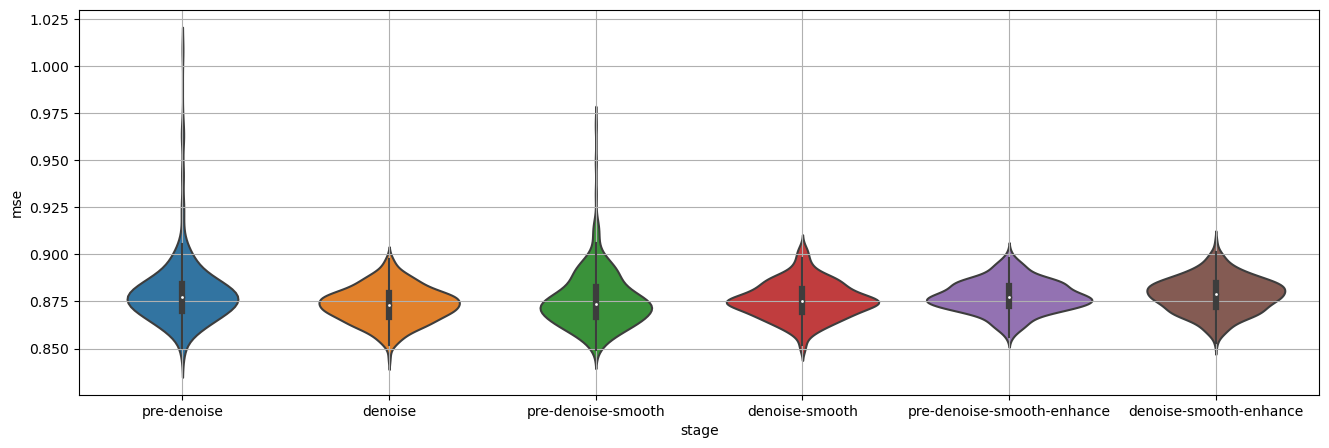

In [21]:
# sns.violinplot(mse_df[~mse_df['stage'].str.contains('pre-')], x='stage', y='mse')
plt.figure(figsize=(16, 5))
sns.violinplot(mse_df, x='stage', y='mse')
plt.grid()

In [24]:
u_stat, p_val = sp.stats.mannwhitneyu(mse_df.loc[mse_df['stage'] == 'denoise', 'mse'], 
                      mse_df.loc[mse_df['stage'] == 'denoise-smooth', 'mse'])

print('p =', p_val, 
      'f =', u_stat / sum(mse_df['stage'] == 'denoise') / sum(mse_df['stage'] == 'denoise-smooth'))

p = 0.011884865098736758 f = 0.434976


In [25]:
u_stat, p_val = sp.stats.mannwhitneyu(mse_df.loc[mse_df['stage'] == 'denoise-smooth', 'mse'], 
                      mse_df.loc[mse_df['stage'] == 'denoise-smooth-enhance', 'mse'])
print('p =', p_val, 
      'f =', u_stat / sum(mse_df['stage'] == 'denoise-smooth') / sum(mse_df['stage'] == 'denoise-smooth-enhance'))

p = 0.00031130454510364076 f = 0.4068


In [29]:
embeddings = []
model.eval()
emb = np.zeros((len(adata), 128))

with torch.no_grad():
    for X in train_loader:
        for i in adata.obs['sample'].unique():
            X = np.array(adata.X[adata.obs['sample'] == i, :])
            y = adata.obs['sample'] == i
            emb[y, :] = model.cell_embed(torch.tensor(X, dtype=torch.float32)[None, :, :].to('cuda')).cpu().detach().numpy()

In [30]:
adata.obsm['X_kuanglu'] = emb

In [33]:
sc.pp.neighbors(adata, use_rep='X_kuanglu')
sc.tl.umap(adata)

C:\Users\lshh\miniconda3\envs\torch_2.0.1\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
C:\Users\lshh\miniconda3\envs\torch_2.0.1\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
C:\Users\lshh\miniconda3\envs\torch_2.0.1\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\lshh\miniconda3\envs\torch_2.0.1\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:39

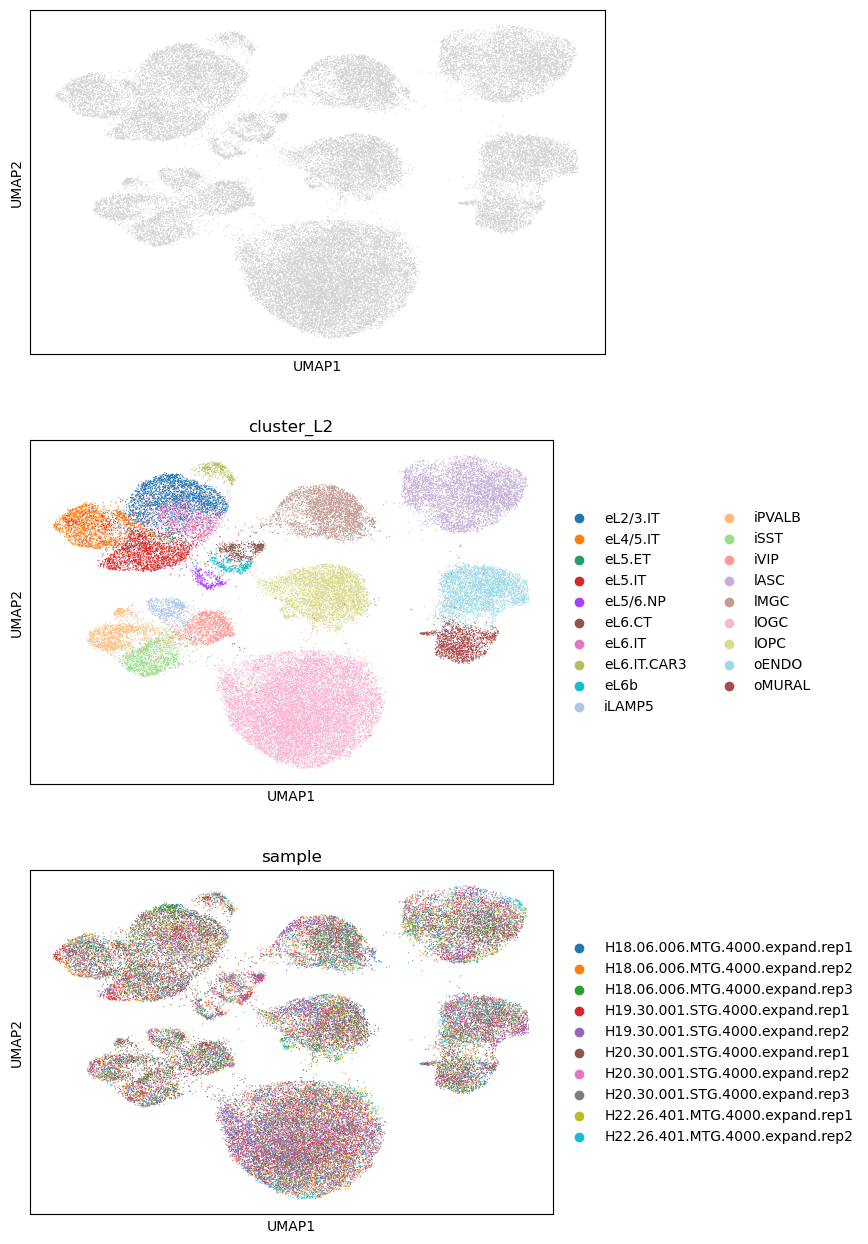

In [34]:
%matplotlib inline
sc.pl.umap(adata, color=[None, 'cluster_L2', 'sample'], ncols=1)
pass

In [31]:
with open("../comparisons/output/human-brain-4000-kuanglu-emb.pkl", 'wb') as f:
    pkl.dump(emb, f)